# Time tracking

- 11/19, 5:30 - 6:00, initial setup, starting scratchwork
- 11/20, 4:45 - 5:30, onto GitHub, got Sinkhorn to run
- 11/21, 3:00 - 4:30, improved Sinkhorn, ran it on MNIST
- 11/22, 5:20 - 7:05, implemented gradients for regularized Sinkhorn
- 11/25, 4:50 - 6:00, first try at gradients for sharp Sinkhorn
- 11/27, 2:15 - 4:45, fixed sharp Sinkhorn code, lots of reading to better understand the literature and what is possible
- 11/28, 12:35 - 3:00, did some digit averaging, tried to vectorize but just settled for a speedup
- 12/8, 12:40 - 2:00, packaged some things into methods, tested again and found things are surprisingly slow
- 12/28, 12:45 - 1:45, got Lloyd working with Sinkhorn
- 1/6, 4:05 - 6:15, cleaned up Lloyd code, tried on all 10 digits
- 1/7, 1:05 - 2:20, k-means++, tried 20 clusters, thought about using color


- Note that this optimal transport package exists: https://pythonot.github.io/
 - But it doesn't have the sharp gradients, so maybe I could improve upon it? Should test how it deals with zero pixels
- Try doing Bregman from this paper later on: https://arxiv.org/pdf/1412.5154.pdf

In [1]:
# Autoreload so we don't have to reimport packages when we change them
%load_ext autoreload
%autoreload 2

In [2]:
## Imports

# Basic
import numpy as np
import matplotlib.pyplot as plt
import random

# My code
import bary

# Data: https://www.tensorflow.org/datasets
import tensorflow_datasets as tfds

# Implementing Sinkhorn

### Basic run

First get it to run on 1D data, and using the differentiability to gradient descent to a fixed measure

In [234]:
# Number of points in 1D
n = 10

# Locations I'll use
x = list(range(n))

# Target measure
## p even though it's not a probability distribution
p = [random.random() for i in range(n)]
p = p / np.sum(p)

# Distance matrix
M = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        M[i,j] = abs(i-j)

In [235]:
l = 10
q = np.zeros(n)
q[0] = sum(p)

bary.sinkhorn(p,q,M,l,50)

array([4.16324842])

In [236]:
# Test
p = np.ones(10) * 0.01
q = np.zeros(10)
p[0] = p[0] + 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = p[3] + 0.4
bary.sinkhorn(p,q,M,50)

array([1.28589744])

In [237]:
# Approx ish
# So it passes
0.3 + 2*0.2 + 0.4 + 0.01 * (1 + 0 + 0 + 1 + 2 + 3 + 4 + 5 + 6 + 7)

1.3900000000000001

In [238]:
# Test
p = np.ones(10) * 0.01
q = np.zeros(10)
p[0] = p[0] + 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = p[4] + 0.4
p = p * 5
q = q * 5
bary.sinkhorn(p,q,M,30)

array([6.42950814])

Ok, looks like the Sinkhorn code is correct. To do though:
- Edit so r = 0 doesn't throw errors
- Run it on some Google Quick Draw! stuff
- Vectorize better for computing distance of one histogram to many

### Refining it

- $r = 0$ doesn't throw errors
- Iteration can be controlled or is set automatically
- More vectorized

In [239]:
# Test
p = np.zeros(10)
q = np.zeros(10)
p[0] = 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = 0.5
bary.sinkhorn(p,q,M,10,20)

array([1.19994503])

In [240]:
# Wasserstein distance
0.3 * 1 + 0.2 * 2 + 0.5 * 1

1.2

So the $r=0$ and variable number of iterations went through without and issue

Now to vectorize better...

In [247]:
A = np.zeros((3,4))
np.shape(A)

(3, 4)

In [248]:
np.shape(A)[1]

4

In [249]:
# Test
p = np.zeros(10)
q = np.zeros(10)
p[0] = 0.5
q[1] = 0.3
q[2] = 0.7
p[3] = 0.5

In [250]:
Q = np.transpose(np.array([q,q,q,q]))
np.shape(Q)

(10, 4)

In [251]:
bary.sinkhorn(p,Q,M,10,20)

array([1.19994503, 1.19994503, 1.19994503, 1.19994503])

Looks like that's working!

In [252]:
# And scaling things gives expected results
bary.sinkhorn(4*p,4*Q,M,10,20)

array([4.79978012, 4.79978012, 4.79978012, 4.79978012])

## Testing on MNIST

Using TensorFlow for easy data management: https://www.tensorflow.org/datasets/catalog/mnist

In [3]:
# Following this example: https://www.tensorflow.org/datasets/overview

ds = tfds.load('mnist', split='train')

In [4]:
# The size of the images
for ex in ds.take(1):
    print(np.shape(ex['image']))

(28, 28, 1)


In [5]:
## Convert to a numpy array of histograms

# Size of histograms
n = 28 * 28

# Number of images to convert
N = 100

# Allocate memory
X = np.zeros((n,N))
y = np.zeros(N)

# Iterate to populate X
i = 0
for ex in ds.take(N):
    # Make sure to normalize too!
    aux = np.ravel(ex['image'].numpy())
    X[:,i] = aux / sum(aux)
    y[i]   = ex['label'].numpy()
    i = i + 1

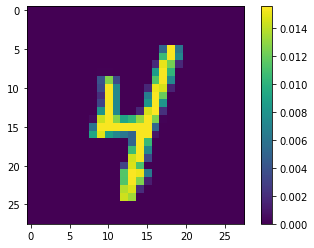

In [6]:
# A quick check that we can recover the original images
img = np.reshape(X[:,0], (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

In [7]:
# Sort things in terms of the labels
sort = np.argsort(y)
y = y[sort]
X = X[:,sort]

In [139]:
# Get M

# To make sure I don't mess up indexing things, I'll set up a list of locations and reshape it into a matrix
# So when I calculate a pairwise distance in the matrix, I can easily associate it to the location in the vector
locations_vec = np.array(range(n))
locations_arr = np.reshape(locations_vec, (28,28))

M = np.zeros((n,n))
# Having 4 "for" loops is a bit embarassing, but I'm not trying to think too hard right now
for i1 in range(28):
    for j1 in range(28):
        for i2 in range(28):
            for j2 in range(28):
                M[locations_arr[i1,j1], locations_arr[i2,j2]] = np.sqrt((i1-i2)**2 + (j1-j2)**2)

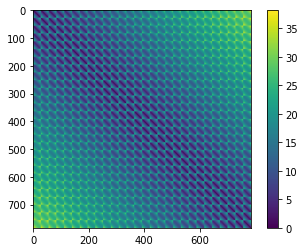

In [9]:
# The plot looks reasonable
plt.imshow(M)
plt.colorbar()
plt.show()

In [11]:
# Compute pairwise sinkhorn divergences

# Using settings from the original Marco Cuturi Sinkhorn paper
l = 9
iterations = 20

K = np.exp(-l * M)

D = np.zeros((N,N))

for i in range(N):
    # Compute the distance from image i to the rest of them
    D[i,:] = bary.sinkhorn_mk(X[:,i],X,M,K,iterations)

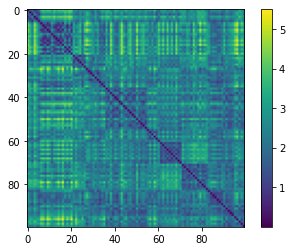

In [12]:
# Plot them
plt.imshow(D)
plt.colorbar()
plt.show()

In [13]:
# Compare to when the digits are equal
B = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        B[i,j] = (y[i] == y[j])

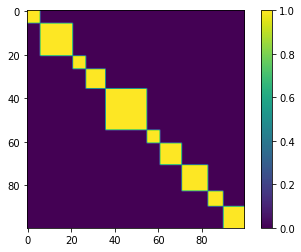

In [312]:
plt.imshow(B)
plt.colorbar()
plt.show()

That looks awesome!

# Differentiability

- Implement the code to calculate gradients of Sinkhorn (maybe start with regularized)
- Test on MNIST data
 - Gradient descent from uniform distribution to a given digit
 - Find an average case digit
- Test on Quick Draw!: https://www.tensorflow.org/datasets/catalog/quickdraw_bitmap

From the "Differential Properties of Sinkhorn" paper, the gradient in the first histogram is given by an optimal dual variable

Comparing the formula in that paper to the formula in the original Sinkhorn paper, it seems we can back this $\alpha_*$ out of the results of the Sinkhorn iteration

So, run the code above to get an MNIST digit

## Regularized

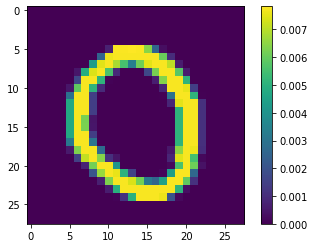

In [71]:
c = X[:,0]
img = np.reshape(c, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

Now I'll do some gradient descent to find that digit

In [40]:
steps = 100
r = np.ones(n) / n
R = np.zeros((n,steps+1))
R[:,0] = r

l = 10
K = np.exp(-l*M)
iterations = 20
eta = 1
#eta = 0.0001

for i in range(steps):
    # Gradient
    alpha = bary.Dsinkhorn_reg(r,c,M,l,K,iterations)
    # Reformat to match shape of r and move opposite that direction
    r = r - eta * np.reshape(alpha,np.shape(r))
    # Keep it nonnegative and unit mass
    r = r * (r>0)
    r = r / sum(r)
    # Save it
    R[:,i+1] = r

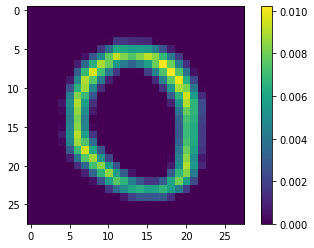

In [43]:
i = 2
img = np.reshape(R[:,i], (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

It works! But for some reason I have to dampen it a whole lot. It seems the gradient is typically orders of magnitude too large?

FIXME: think more about this issue. I'll ignore it for now.

Ok, later I thought about it and figured out $\alpha_*$ was wrong and fixed that. Now the only remaining issue is with the support, that once a pixel is set to zero it's gone for good and we never color it again. Maybe the way to fix this is to use another algorithm, or add a bit of noise at each step.

Now let's try getting an average case digit:
- Run the digit sorting code above
- Pick out some 7s
- Do the thing

In [44]:
C = X[:,71:83]

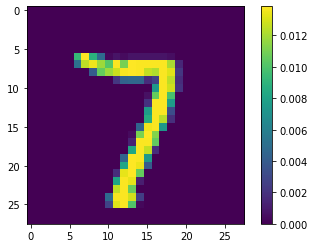

In [45]:
c = C[:,0]
img = np.reshape(c, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

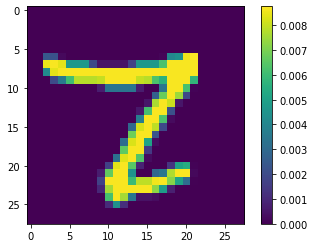

In [46]:
c = C[:,-1]
img = np.reshape(c, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

In [47]:
np.shape(C)

(784, 12)

In [63]:
steps = 100
r = np.ones(n) / n
R = np.zeros((n,steps+1))
R[:,0] = r

l = 10
K = np.exp(-l*M)
iterations = 20
eta = 1
#eta = 0.0001

for i in range(steps):
    # Gradient
    alpha = bary.Dsinkhorn_reg(r,C,M,l,K,iterations)
    # Average the gradients and modify r
    r = r - eta * (alpha @ np.ones(12)) / 12
    # Keep it nonnegative and unit mass
    r = r * (r>0)
    r = r / sum(r)
    # Save it
    R[:,i+1] = r

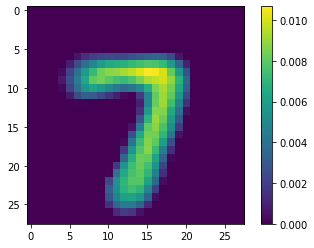

In [65]:
i = 2
img = np.reshape(R[:,i], (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

Again, after the edit I don't have to use eta, but I run into the support issue.

This is really cool. Hopefully I'm overlooking something and I can get rid of the eta. Either way, I can change eta over time (i.e. increase it after 10 gradient steps). Let's try that:

In [364]:
# Input: current r, C for the target histograms, eta to use, number of steps to do, and M,l,iterations
# Output: R, the steps
def descend(r,C,steps,eta,M,l,iterations=20):
    
    # Set up thingies
    k = np.shape(C)[1]
    K = np.exp(-l*M)
    
    # Iterate
    for i in range(steps):
        # Gradient
        alpha = bary.Dsinkhorn_reg(r,C,M,l,K,iterations)
        # Average the gradients and modify r
        r = r - eta * (alpha @ np.ones(k)) / k
        # Keep it nonnegative and unit mass
        r = r * (r>0)
        r = r / sum(r)
    
    # Return
    return r

In [370]:
np.shape(r)

(784,)

In [371]:
n = 28*28
r = np.ones(n) / n

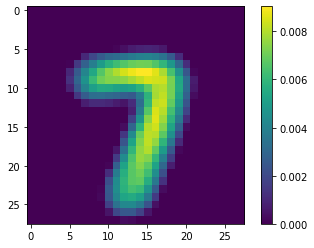

In [373]:
## Version 1

n = 28*28
r = np.ones(n) / n

# Descend
steps = 20
eta = 0.0001
r = descend(r,C,steps,eta,M,l)

# Plot
img = np.reshape(r, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

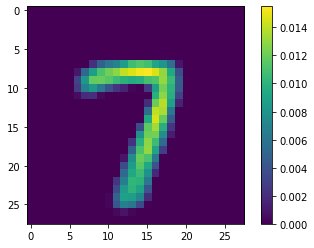

In [374]:
## Version 2

n = 28*28
r = np.ones(n) / n

# Descend
steps = 10
eta = 0.0001
r = descend(r,C,steps,eta,M,l)
steps = 10
eta = 0.001
r = descend(r,C,steps,eta,M,l)

# Plot
img = np.reshape(r, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

So yes, increasing eta at the right time can speed up convergence :)

## Sharp

Now compute gradients with the sharp Sinkhorn

First I'll try coding up the stuff from the Diffy Sink paper in **bary.py**.

Notes:
- The p. 23 formula takes some parsing to realize we're solving a system $K f = g$ for $f$
- To figure out $g$ and $K$, we need
 - $T$, $\overline{T}$
 - $L$

**Ok** important thing: I realized I basically just guessed at how to get $\alpha_*$ from $u$ by looking at the formulas and pattern matching, but the way I did it leaves an extra degree of freedom, so it doesn't actually find $\alpha_*$. Looking at the Fast Barycenter paper, p. 6 gives the right way to get $\alpha_*$ from $u$, which is to ensure its sum is zero.

I fixed that and the previous results look better, but now the FIXME issue is that once a pixel value is set to zero it never comes back, which isn't great. Idk how to fix that.

Ok let's see if the code works. Run the above stuff to load the MNIST things, then for a single digit...

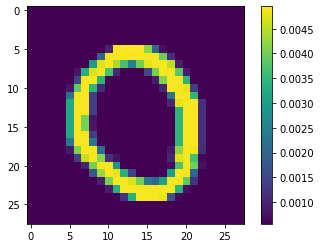

In [147]:
# Add a bit of "noise"
c = X[:,0]
c = c + 0.001 * np.ones(28*28)
c = c / sum(c)
img = np.reshape(c, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

In [158]:
steps = 10
n = 28*28
r = np.ones(n) / n
R = np.zeros((n,steps+1))
R[:,0] = r

l = 10
K = np.exp(-l*M)
iterations = 20
eta = 1
#eta = 0.0001

for i in range(steps):
    # Gradient
    gradient = bary.Dsinkhorn(r,c,M,l,K,iterations)
    # Reformat to match shape of r and move opposite that direction
    r = r - eta * np.reshape(gradient,np.shape(r))
    # Keep it nonnegative and unit mass
    r = r * (r>0)
    r = r / sum(r)
    # Save it
    R[:,i+1] = r

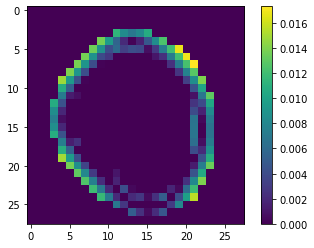

In [160]:
i = 2
img = np.reshape(R[:,i], (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

Ok, a lot of entries of $c$ are zero which is an issue. I added some "noise" to avoid that. But still the gradient seems to be wrong. Need to go back and check the code for Dsinkhorn.

Next I used the pseudocode on p. 8 (modified the last line since it should have that the sum of the entries of the output is zero), and I get an anti-zero. i.e. It's descending in the wrong direction? I'll give it a minus sign. My guess is that the Diffy Sinkhorn paper computes the negative gradient since it intends it to be used directly for gradient descent.

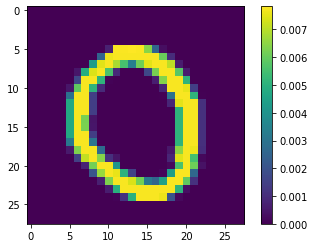

In [82]:
# Now without noise
c = X[:,0]
c = c / sum(c)
img = np.reshape(c, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

In [83]:
steps = 1
r = np.ones(n) / n
R = np.zeros((n,steps+1))
R[:,0] = r

l = 10
K = np.exp(-l*M)
iterations = 20
eta = 1
#eta = 0.0001

for i in range(steps):
    # Gradient
    gradient = bary.Dsinkhorn(r,c,M,l,K,iterations)
    # Reformat to match shape of r and move opposite that direction
    r = r - eta * np.reshape(gradient,np.shape(r))
    # Keep it nonnegative and unit mass
    r = r * (r>0)
    r = r / sum(r)
    # Save it
    R[:,i+1] = r

C:\Users\Nicolas Bolle\Documents\Projects\barycenters\bary.py:231: RuntimeWarning: divide by zero encountered in reciprocal
  D2 = np.diag(np.reciprocal(c[:,i])) #np.diag(np.reciprocal(np.transpose(Tbar) @ np.ones(n)))
C:\Users\Nicolas Bolle\Documents\Projects\barycenters\bary.py:234: RuntimeWarning: invalid value encountered in matmul
  H = D1 - Tbar @ D2 @ np.transpose(Tbar)
C:\Users\Nicolas Bolle\Documents\Projects\barycenters\bary.py:237: RuntimeWarning: invalid value encountered in matmul
  f = L @ np.ones(m) - Tbar @ D2 @ np.transpose(Lbar) @ np.ones(n)


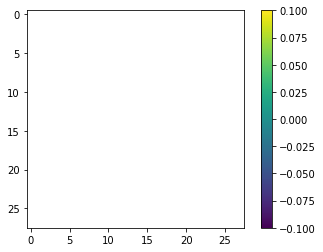

In [84]:
i = 1
img = np.reshape(R[:,i], (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

In [81]:
D1 = a
D2 = b
rp = c

Ok, so it doesn't have a way to deal with when entries of $c$ are zero

Also, modifying the code suggests that earlier funny behavior was party because **np.transpose(Tbar) @ np.ones(n)** is not **cbar**. Or actually with **rbar**. Some testing shows that the equality that should hold does not hold! Let's test that a bit more:

In [127]:
K = np.exp(-l * M)

# Remove zeros in r to avoid division by zero
I = r > 0
r = r[I]
M = M[I,:]
K = K[I,:]

# Reshape c
if len(np.shape(c)) == 1:
    c = np.reshape(c,(len(c),1))

# Run the iteration
u,v = bary._uv_iteration(r,c,M,K,1000)

In [128]:
T = np.diag(np.reshape(u,(len(u),))) @ K @ np.diag(np.reshape(v,(len(v),)))

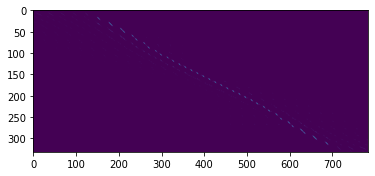

In [146]:
plt.imshow(T)
plt.show()

In [130]:
col_sums = np.sum(T,axis=0)
row_sums = np.sum(T,axis=1)

In [131]:
np.max(np.abs(col_sums - c))

0.0043900985819878904

In [132]:
np.max(np.abs(row_sums - r))

3.620078154014002e-05

So doing more iterations can make the row/column sums of T more accurate, but they'll still be off by about a few thousandths

**So:**
- Find a fix for pixels getting stuck at zero in $r$
- Find a fix for pixels being zero in $c$ for sharp gradients
- (Vectorize sharp gradients for speed)
- Test on more data, especially many digits

For the first two, I'll read through the papers and see how they deal with it
- Sinkhorn: nothing here, since they don't deal with gradients. If a component is zero, we can just ignore it for the distance computation. And we don't have to think about it "wanting to be nonzero".
- Fast Barycenters: "other algorithms exist (Knight and Ruiz, 2012)" could be helpful. They don't mention anything about $r=0$ being an issue for gradients. Or anything on shrinking the step size, or making sure the images during the gradient descent have nonnegative pixel values.
 - Looking at that reference, it's just talking about alternatives to **bary._uv_iteration()**. I think the key issue I'm running into is that Sinkhorn is differentiable in the interior of its domain (by Diffy Sink) but things can get weird at the boundary.
- Diffy Sink: p. 12 they use [5] for Regularized, [16] for Sharp (this is the Fast Bary paper). And I should probably look at [11] to better understand the SVM for reconstruction stuff on p. 13.
 - [5] talks about "Bregman Projections" which have an algorithm similar to Sinkhorn-Knopp but better in some way?
 - [11] talks generally about reconstruction-like problems. I think what I got from it is that given the top half of an image, we can compute similarity scores to our training data and then do the Sinkhorn gradient descent with respect to these coefficients to converge to a full image, respecting the similarity of our input to the training data. There's some cool ideas here about how to reduce the search space for a reconstruction. They also apply it to predicting movie ratings.

So here are some more thoughts:
- Adding noise to things can remove the zero entries and is probably good enough
 - Maybe if I treat division by zero as $+\infty$ then things work out?? I doubt it though
- For speed: check how much faster Regularized Sinkhorn is than Sharp Sinkhorn, since it could help to use the former for the first few iterations for speed (Diffy Sink p. 12 does this)
- Try vectorizing the sharp Sinkhorn **for** loop
- Later on, try out the image reconstruction via gradient descent, mimicking [11] in Diffy Sink

## Average case digits

Make sure to add noise throughout to avoid division by zero

In [3]:
## Get M

n = 28 * 28

# To make sure I don't mess up indexing things, I'll set up a list of locations and reshape it into a matrix
# So when I calculate a pairwise distance in the matrix, I can easily associate it to the location in the vector
locations_vec = np.array(range(n))
locations_arr = np.reshape(locations_vec, (28,28))

M = np.zeros((n,n))
# Having 4 "for" loops is a bit embarassing, but I'm not trying to think too hard right now
for i1 in range(28):
    for j1 in range(28):
        for i2 in range(28):
            for j2 in range(28):
                M[locations_arr[i1,j1], locations_arr[i2,j2]] = np.sqrt((i1-i2)**2 + (j1-j2)**2)

In [4]:
## Load MNIST data
ds = tfds.load('mnist', split='train')


## Convert to a numpy array of histograms

# Size of histograms
n = 28 * 28

# Number of images to convert
N = 1000

# Allocate memory
X = np.zeros((n,N))
y = np.zeros(N)

# Iterate to populate X
i = 0
for ex in ds.take(N):
    # Make sure to normalize too!
    aux = np.ravel(ex['image'].numpy())
    X[:,i] = aux / sum(aux)
    y[i]   = ex['label'].numpy()
    i = i + 1

    
## Sort things in terms of the labels
sort = np.argsort(y)
y = y[sort]
X = X[:,sort]

In [10]:
## Pick out all the 7s
I = (y == 7)
X7 = X[:,I]
y7 = y[I]

In [17]:
## Add a bit of "noise" to them

# This governs how much mass to dedicate to noise
noise = 0.1

# Add the noise
X7noise = X7 + (noise / n) * np.ones(np.shape(X7))

# Normalize
for i in range(np.shape(X7noise)[1]):
    X7noise[:,i] = X7noise[:,i] /np.sum(X7noise[:,i])

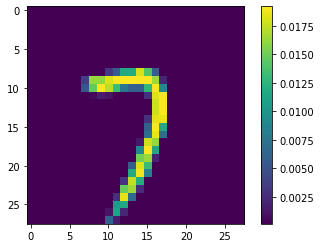

In [18]:
# Plot a digit
c = X7noise[:,0]
img = np.reshape(c, (28,28))
plt.imshow(img)
plt.colorbar()
plt.show()

In [43]:
# Number of digits
np.shape(X7noise)

(784, 94)

In [106]:
## Gradient descent
# I scale the gradient to have 1-norm of one, which seems reasonable enough
# Would still like to know why the gradients I get are so big

# Parameters
steps = 20
l = 10
iterations = 20
eta = 0.5

# Setup
c = X7noise
r = np.ones(n) / n
R = np.zeros((n,steps+1))
R[:,0] = r
K = np.exp(-l*M)

# For keeping track of gradients
G = np.zeros((n,steps+1))

# Iterate
for i in range(steps):    
    # Gradient
    gradients = bary.Dsinkhorn(r,c,M,l,K,iterations)
    
    # Average together the gradients, reformat to match shape of r, rescale, and move opposite that direction
    g = np.reshape(np.mean(gradients, axis=1),np.shape(r))
    g = (eta / np.sum(np.abs(g))) * g
    r = r - g
    
    # Keep it nonnegative and unit mass
    r = r * (r>0)
    r = r / sum(r)
    
    # Save it
    R[:,i+1] = r
    G[:,i+1] = g

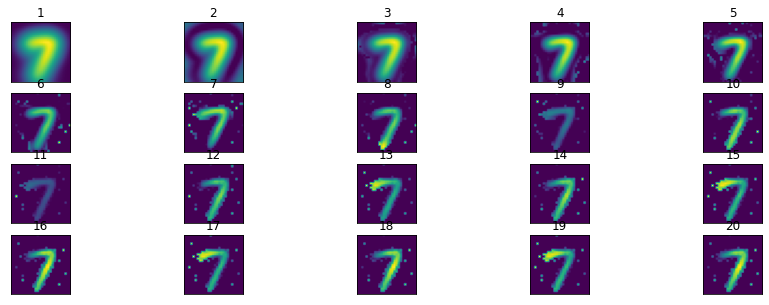

In [107]:
## Plot iterates

# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(15,5))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    ax.imshow(np.reshape(R[:,i], (28,28)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))

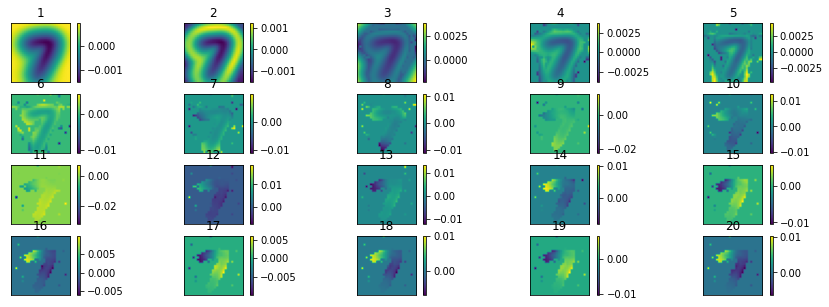

In [108]:
## Plot gradients

# Set up the axes
fig, axs = plt.subplots(4,5,figsize=(15,5))

# Iterate over the plotting locations
i = 0
for ax in axs.ravel():
    i = i + 1
    im = ax.imshow(np.reshape(G[:,i], (28,28)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(i))
    plt.colorbar(im, ax=ax)

Ok I still don't love the "gradients are huge" issue, but this is fine for now

Before moving on, let's try to vectorize **bary.DSinkhorn()**

Ok I tried and it was much slower. I could set it up with tensors, but since fundamentally I'm just doing a bunch of matrix-vector stuff I think the tensors are overkill. But I did learn a good amount about working with tensors, so I'm not as scared of them anymore. Instead, I went into the old **bary.DSinkhorn()** code and modified it to simplify some operations. i.e. swapped multiplication with ones vectors out with sums, and instead of working with diagonal matrices I just did elementwise multiplication + broadcasting.

This sped things up a bunch: instead of 1 or 2 minutes for 20 descent steps, it now takes about 20 seconds.

I think that's it for today. Next time I wanna do more digit averaging with this faster code, and think a bit more about the gradients being really large. Does the scaling of $M$ affect things?

It's been a while, lol; classes are finishing so it's been a bit busy. Let's try to code up the above a bit more nicely in **bary**:
- Code to load the MNIST digits
- Code to plot them
- Code to do the barycenter computations

In [3]:
# Load MNIST data
M, X, y = bary.load_MNIST(1000)

# Sort things in terms of the labels
sort = np.argsort(y)
X = X[:,sort]
y = y[sort]

In [4]:
# Grab digit 0

# i will be the index of the digit after the last 0
i = 0
while True:
    if y[i] == 1:
        break
    else:
        i = i + 1

Xp = X[:,:i]
yp = y[:i]

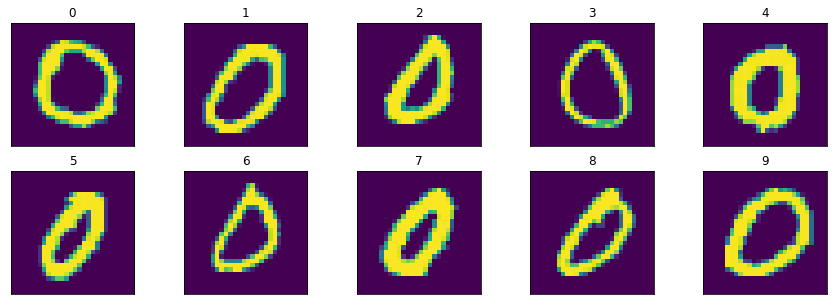

In [5]:
# Plot some
bary.plot_digits(Xp[:,-10:])

In [10]:
r,R,G = bary.sinkhorn_barycenter(M, Xp, noise = 0.01, iterations = 30, steps = 4)

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

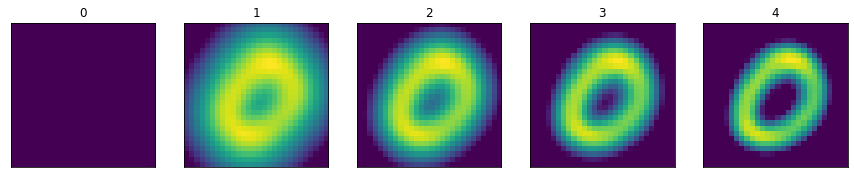

In [11]:
# Plot the results
bary.plot_digits(R)

Not sure why it's so slow....previously it would run 20 iterations in a minute or so :/

Try running the previous code with 7s, and then this new code with 7s and compare. Why is it so slow now? And figure out why the barycenter 0 looks like an 8...is there a middle line in some zeros that makes this harder?

Lmao it was slow because I was trying to average together every single digit, which is a lot of data and probably a lot of steps for gradient descent!

These results looks seriously amazing

# Clustering

Try to do k-means ish stuff. Ex. "discover" that there are 2 clusters of sevens: with and without the middle line.

In [4]:
# Pick out 0s and 1s

# i will be the index of the digit after the last 1
i = 0
while True:
    if y[i] == 2:
        break
    else:
        i = i + 1

Xp = X[:,:i]
yp = y[:i]

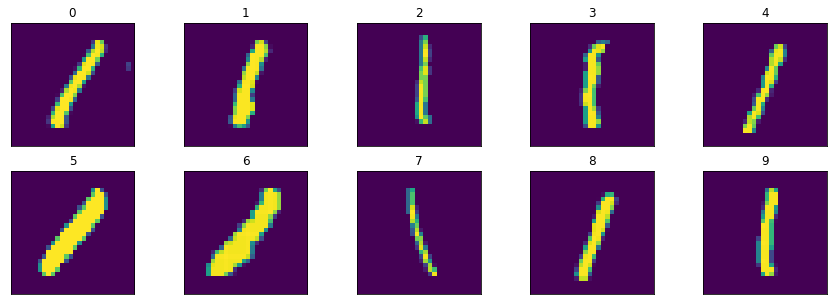

In [5]:
# Plot some
bary.plot_digits(Xp[:,-10:])

In [6]:
# Cluster!
k = 2
c, r, R = bary.k_means_sinkhorn_barycenter(M, Xp, k, noise = 0.01, eta = 0.5, l = 10, iter_sink = 20, iter_Dsink = 20, iter_grad = 4, iter_lloyd = 10)

Lloyd's algorithm progress:   0%|          | 0/10 [00:00<?, ?it/s]

start clusters
end clusters
start barycenters


Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

end barycenters
start clusters
end clusters
start barycenters


Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

end barycenters
start clusters
end clusters
start barycenters


Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

end barycenters
start clusters
end clusters
start barycenters


Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

end barycenters
start clusters
end clusters
start barycenters


Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

end barycenters
start clusters
end clusters
start barycenters


Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

end barycenters
start clusters
end clusters
start barycenters


Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

end barycenters
start clusters
end clusters
start barycenters


Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

end barycenters
start clusters
end clusters
start barycenters


Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

end barycenters
start clusters
end clusters
start barycenters


Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

Gradient descent progress:   0%|          | 0/4 [00:00<?, ?it/s]

end barycenters


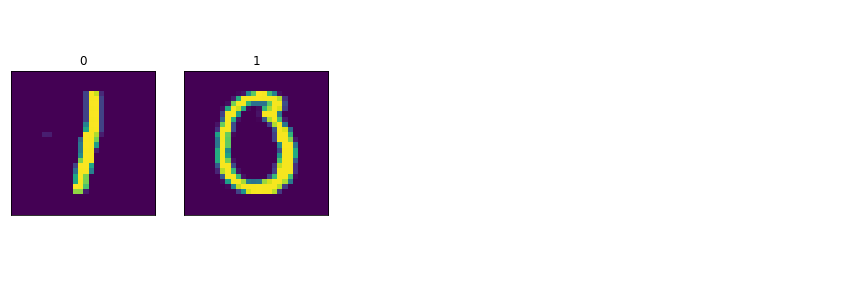

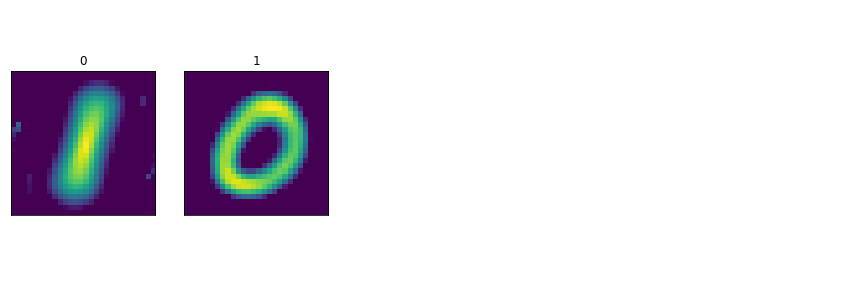

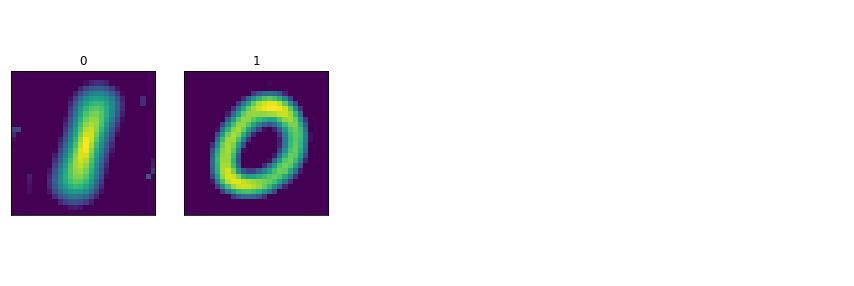

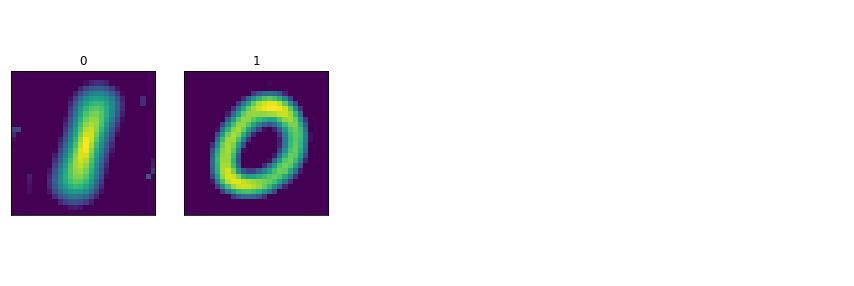

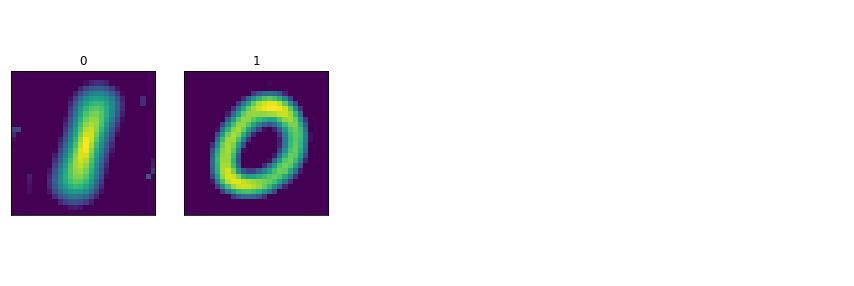

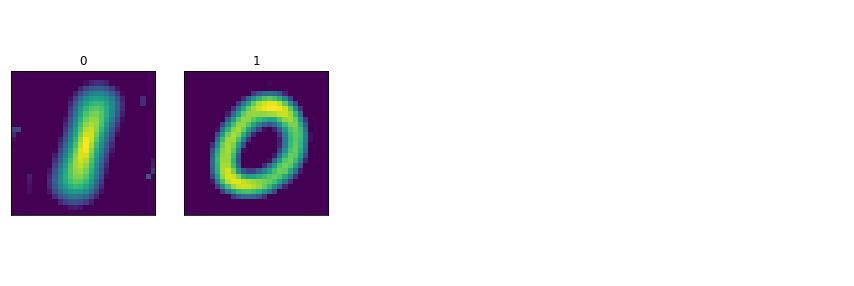

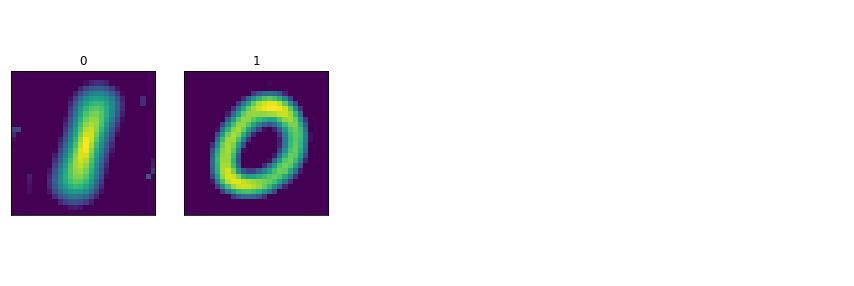

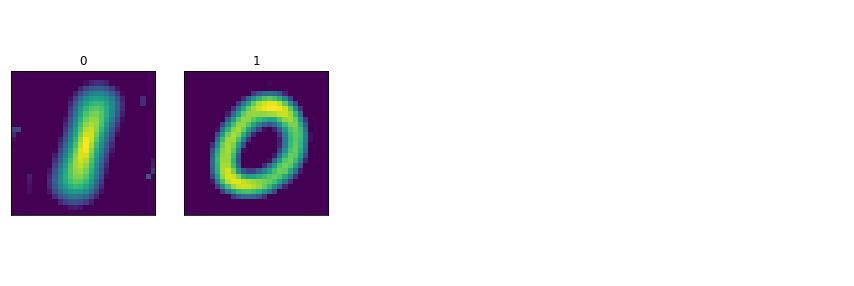

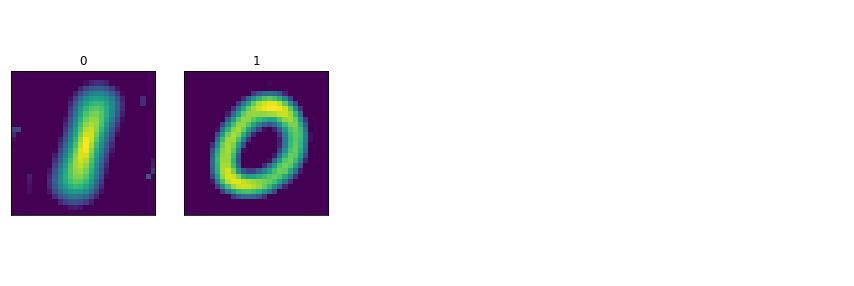

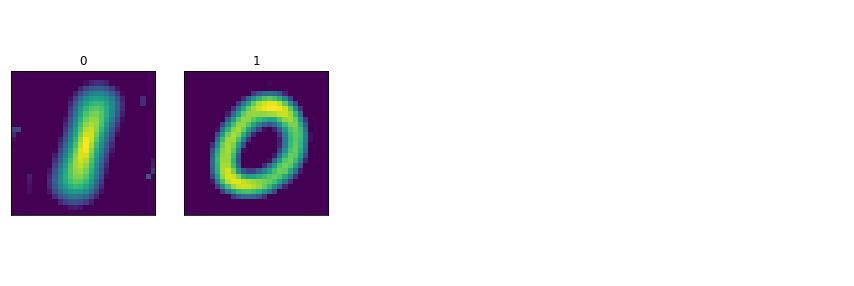

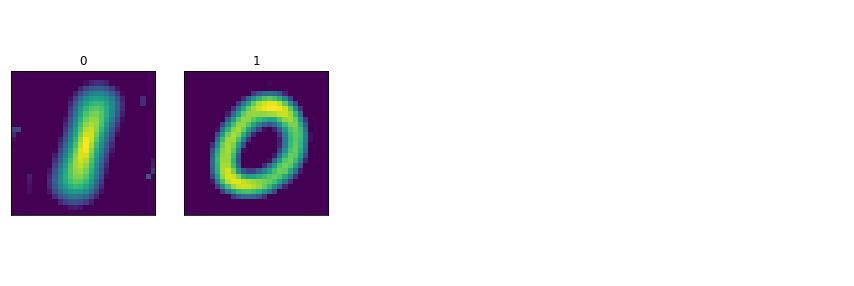

In [7]:
# Plot the results
nn = np.size(R, axis = 2)
for i in range(nn):
    bary.plot_digits(R[:,:,i])

Ok that's awesome. I should clean up the code a little, with a utility version of **sinkhorn_barycenter()** so it's faster and I don't get unnecessary progress bars.

Once that's done, do it on more data! Especially on 7s that include some line-through-the-middle ones.

Ok, the utility version **_sinkhorn_barycenter()** has been made. It took 2 tries, since the first try I accidentally ignored the clusters altogether so it was just computing the average digit of these 0s and 1s. I stashed changes and redid it, testing at each step, and after a bit I realized what went wrong originally. Glad that it was just a small error on my part.

In [47]:
# Cluster!
k = 2
c, r, R = bary.k_means_sinkhorn_barycenter(M, Xp, k, p = 0.01, noise = 0.01, eta = 1, l = 10, iter_sink = 20, iter_Dsink = 20, iter_grad = 4, iter_lloyd = 3)

Lloyd's algorithm progress:   0%|          | 0/3 [00:00<?, ?it/s]

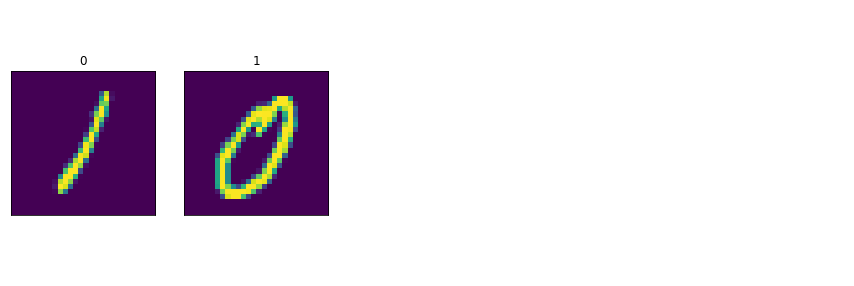

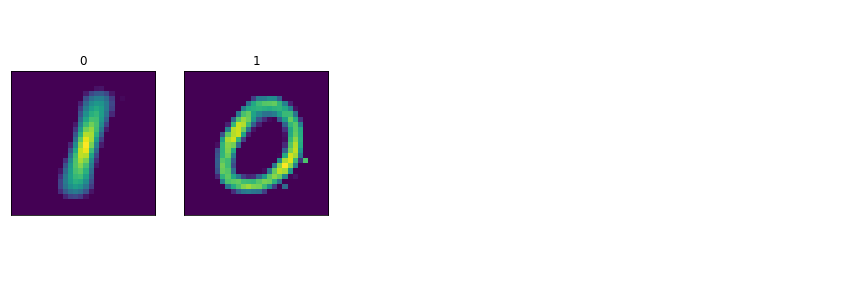

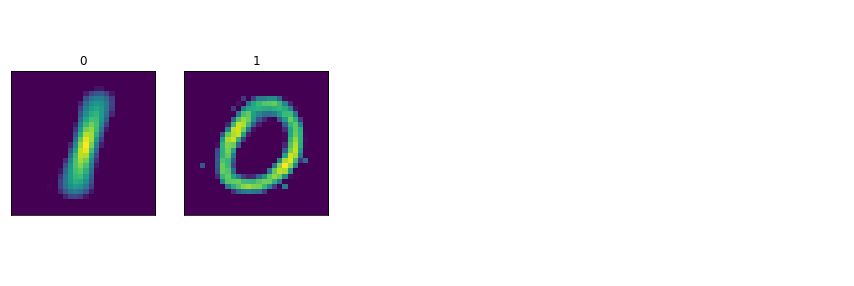

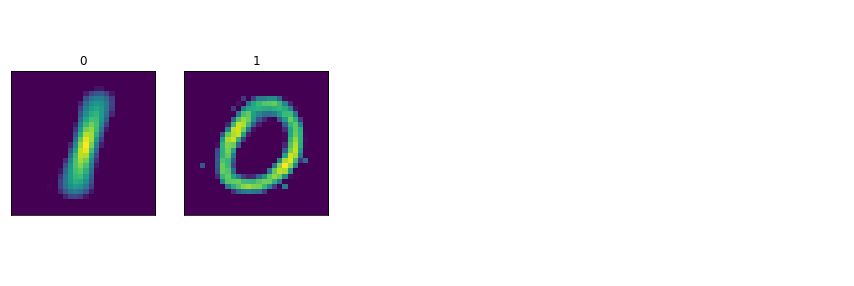

In [48]:
# Plot the results
nn = np.size(R, axis = 2)
for i in range(nn):
    bary.plot_digits(R[:,:,i])

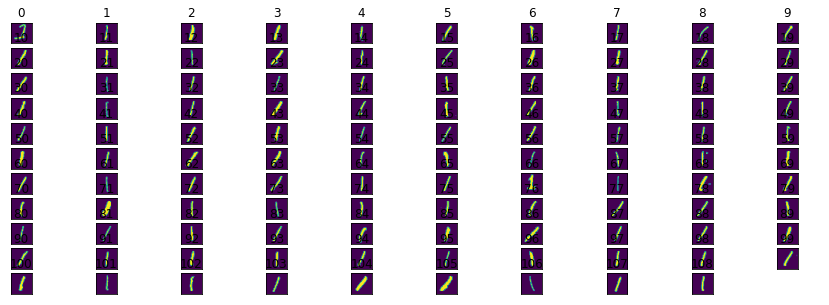

In [49]:
# Visualize cluster 0
I = (c == 0)
bary.plot_digits(Xp[:,I], width = 10)

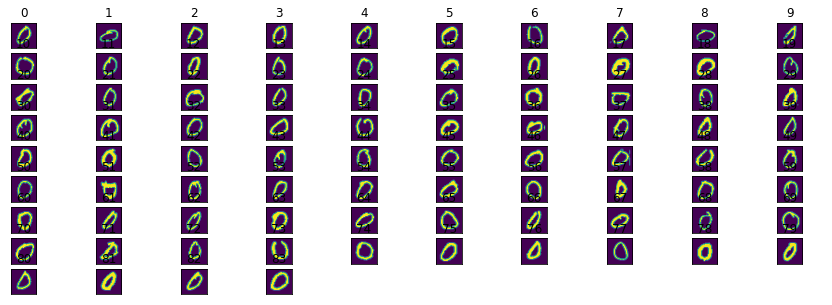

In [50]:
# Visualize cluster 1
I = (c == 1)
bary.plot_digits(Xp[:,I], width = 10)

Great job at recovering clusters!

Now for throwing all the data at it

In [32]:
# Cluster all the digits
k = 10
c, r, R = bary.k_means_sinkhorn_barycenter(M, X, k, noise = 0.01, eta = 1, l = 10, iter_sink = 20, iter_Dsink = 20, iter_grad = 4, iter_lloyd = 10)

Lloyd's algorithm progress:   0%|          | 0/10 [00:00<?, ?it/s]

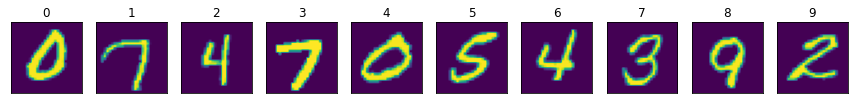

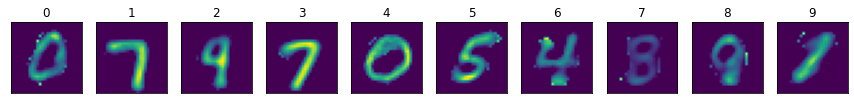

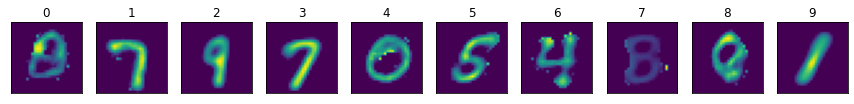

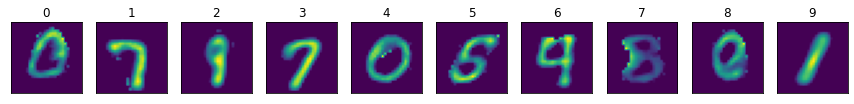

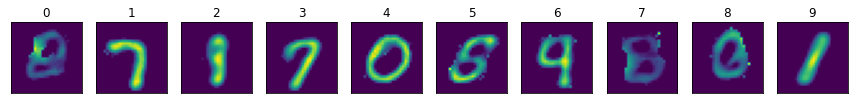

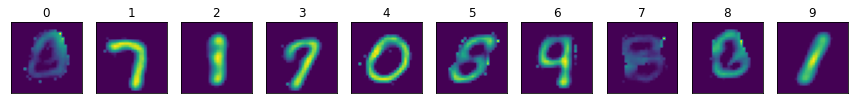

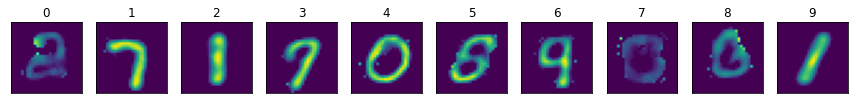

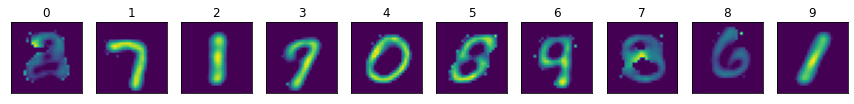

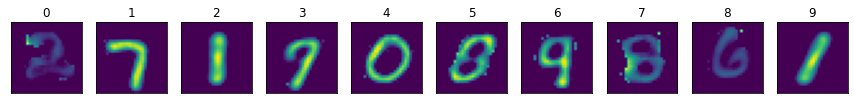

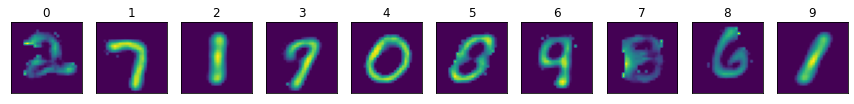

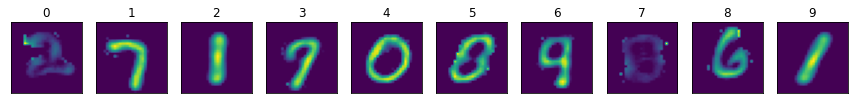

In [33]:
# Plot the results
nn = np.size(R, axis = 2)
for i in range(nn):
    bary.plot_digits(R[:,:,i], width=10)

Ok it's clearly trying, but having a hard time :(

But it does look like it's doing it! For example, note the 8th column how the initial guess of 9 morphed into a 6

Should add k-means++ initialization -> next time

Ok I think I coded up the k-means++ correctly. A bit worried that when passing weights to **np.random.choice()** they won't sum to 1 because of numerical error but let's see...running it on the 0/1 data,

In [18]:
# Cluster!
k = 2
c, r, R = bary.k_means_sinkhorn_barycenter(M, Xp, k, p = 0.01, noise = 0.01, eta = 1, l = 10, iter_sink = 20, iter_Dsink = 20, iter_grad = 4, iter_lloyd = 3)

Initializing...
Done initializing


Lloyd's algorithm progress:   0%|          | 0/3 [00:00<?, ?it/s]

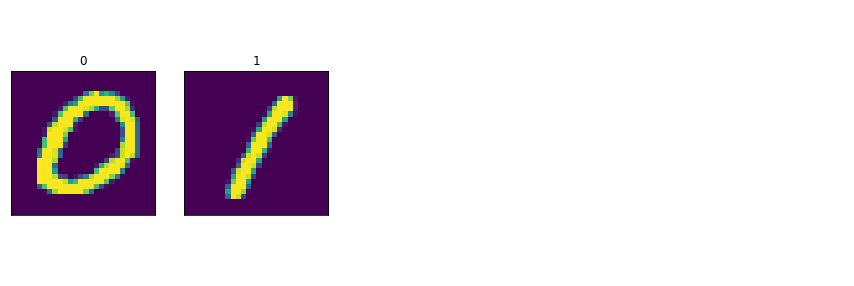

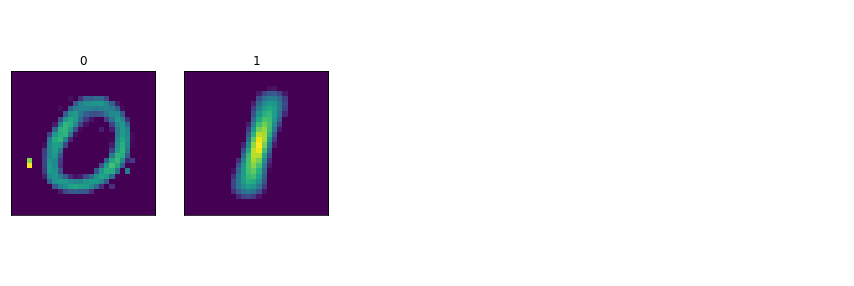

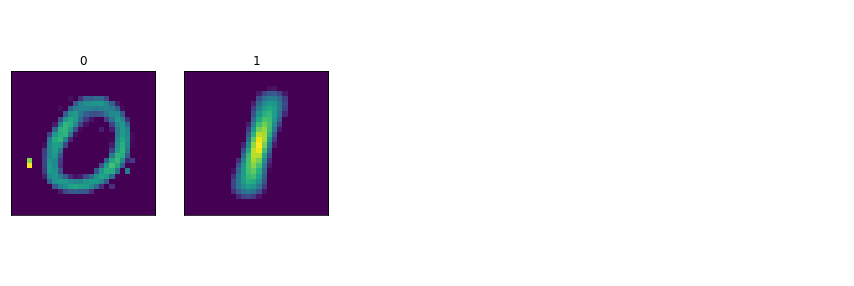

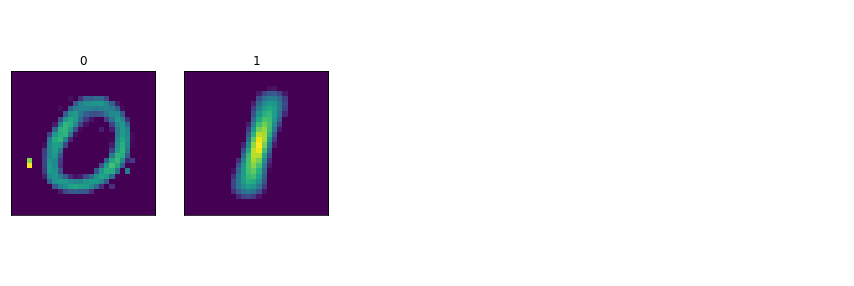

In [19]:
# Plot the results
nn = np.size(R, axis = 2)
for i in range(nn):
    bary.plot_digits(R[:,:,i])

Ok, looks normal enough and it did pick different digits. So let's try with all 10 digits!

In [20]:
# Cluster all the digits
k = 10
c, r, R = bary.k_means_sinkhorn_barycenter(M, X, k, noise = 0.01, eta = 1, l = 10, iter_sink = 20, iter_Dsink = 20, iter_grad = 4, iter_lloyd = 10)

Initializing...
Done initializing


Lloyd's algorithm progress:   0%|          | 0/10 [00:00<?, ?it/s]

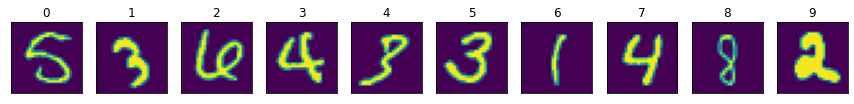

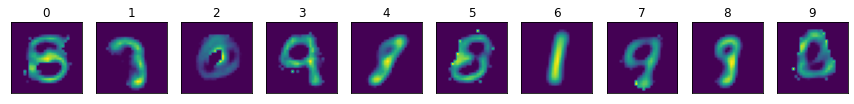

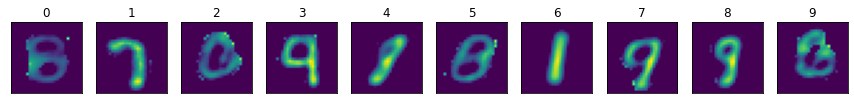

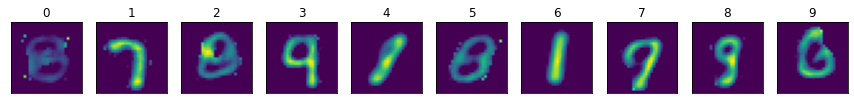

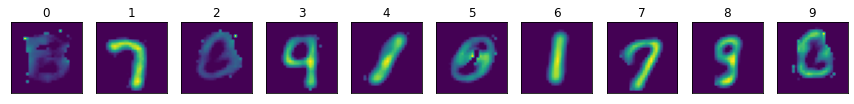

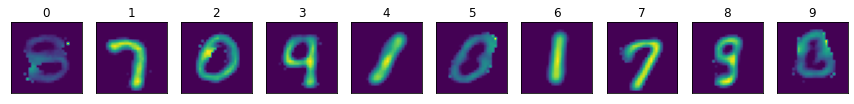

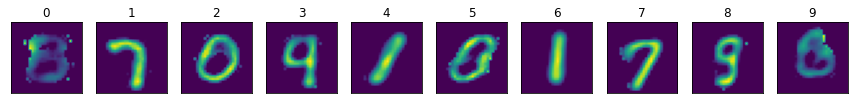

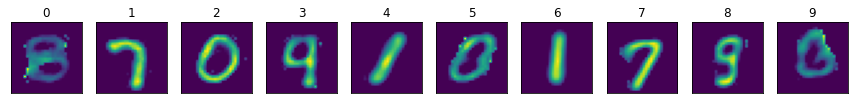

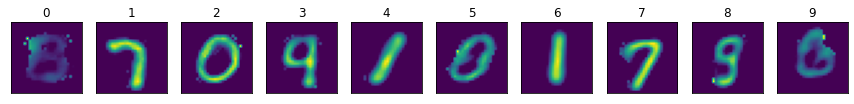

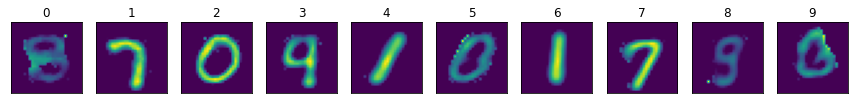

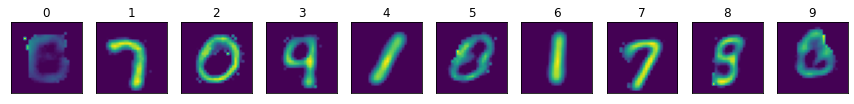

In [21]:
# Plot the results
nn = np.size(R, axis = 2)
for i in range(nn):
    bary.plot_digits(R[:,:,i], width=10)

Just from the first few iterations, **tqdm** tells me it's running in about half the time as without k-means++. Good sign.

But in the end it ended up looking like the previous run :(

Maybe I should add more clusters? Say 20, so it has more than enough for all the different varieties of digits. I could even run the clustering with $k=1,...,20$ and see how the mean/median distance from center of cluster varies.

In [22]:
# Cluster all the digits
k = 20
c, r, R = bary.k_means_sinkhorn_barycenter(M, X, k, noise = 0.01, eta = 1, l = 10, iter_sink = 20, iter_Dsink = 20, iter_grad = 4, iter_lloyd = 10)

Initializing...
Done initializing


Lloyd's algorithm progress:   0%|          | 0/10 [00:00<?, ?it/s]

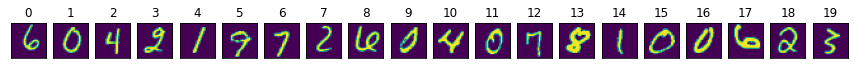

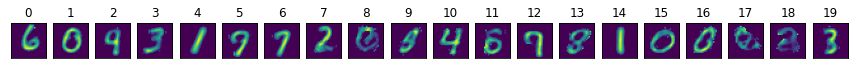

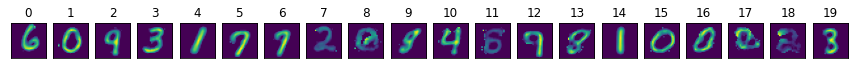

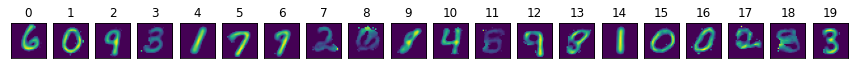

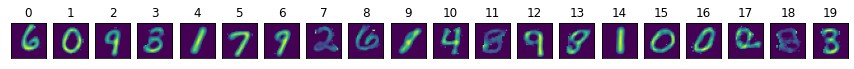

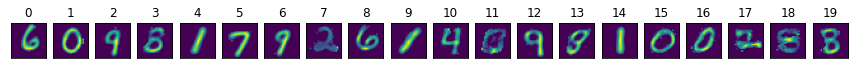

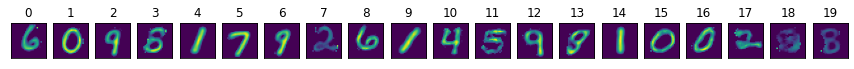

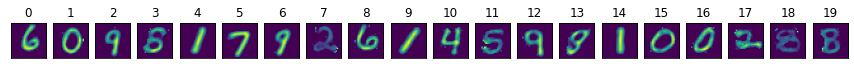

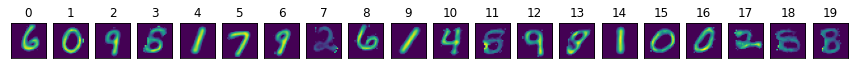

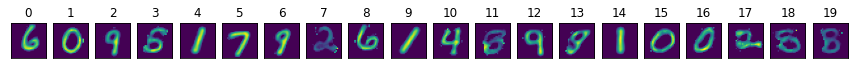

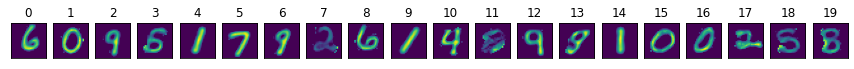

In [23]:
# Plot the results
nn = np.size(R, axis = 2)
for i in range(nn):
    bary.plot_digits(R[:,:,i], width=20)

It seems the runtime roughly doubled, which makes sense.

The outcome looks better than before, but that might be just because it picked out the clusters better in the beginning. But you can still see digits change over time, so I think it's doing its job. I should try running this for say 100 iterations, which would be nearly 3 hours, to see how it changes long-term.

# Image reconstruction

Mimicking [11] in Diffy Sink (see previous note)

# With color?

Would be cool to see if these ideas can be adapted to work with color images

Might try changing to HSL space or something? Look into metrics on color images.

This article is interesting: https://towardsdatascience.com/image-processing-and-optimal-transport-f707c7296b67

For grayscale images, instead of doing mass transport to measure similarity it does mass transport to recolor an image. So they end up transporting 1D histograms of pixel intensities, and using the transport to recolor pixels. I think this is equivalent to playing around with a (monotonic increasing) color curve to match the first image to the target image in terms of color profile.

Cool idea, but I'm not sure how useful it would be in practice. You can use mass transport theory to get an easy color remapping, since you just sort the 1D histograms and match them up, but if you're recoloring an image programmatically then working in HSL space and tweaking color curves globally seems like a better move. But if you want a good recoloring, you should really be doing it by hand; I can't imagine having to recolor dozens of images in a way that regular images filters can't handle.

Transporting histograms over $256^3$ points (in either RGB or HSL space) seems reasonable for recoloring, but again idk how good the result would be, especially since you can have issues where you "run out" of a color halfway through coloring in an object! And the fact that your metric on the cube of RGB/HSL values might take some thinking, in how you're weighting the relative importance in preserving each of the 3 characteristics.

This https://www.kernel-operations.io/geomloss/_auto_examples/optimal_transport/plot_optimal_transport_color.html gives a good visualization of this idea. But yeah, it looks pretty useless.